# FFS nucleation rate calculation examples for "Pattern recognition in the nucleation kinetics of non-equilibrium self-assembly".

This notebook shows nucleation rate calculations for [Evans, C. G., O’Brien, J., Winfree, E. & Murugan, A. Pattern recognition in the nucleation kinetics of non-equilibrium self-assembly. Nature 625, 500–507 (2024)](https://dx.doi.org/10.1038/s41586-023-06890-z).  It uses sequence-dependent binding energies, using [Alhambra](https://github.com/DNA-and-Natural-Algorithms-Group/alhambra) for the tileset definition and integration with rgrow.


In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import alhambra
import polars as pl
import re

In [3]:
ts_base = alhambra.TileSet.from_file("evans2024-pattern-recognition-alhambra.json")

In [4]:
ts_base.params['concentration'] = 50 # in nM, base concentration for tiles.
ts_base.params['alpha'] = -7.1 # alpha parameter for kTAM; this is what we use in SHAM
ts_base.params['glue-handling'] = 'orthogonal' # don't model interactions between non-WC pairs
#ts_base.params['glue-handling'] = 'full' # model interactions between non-WC pairs using Stickydesign energetics.
ts_base.params['fission'] = 'keep-weighted' # when structures split, randomly keep one, weighting by size
ts_base.params['model'] = 'KTAM' # use the kTAM
ts_base.params['chunk-handling'] = 'detach' # allow dimers to detach from the structure
ts_base.params['chunk-size'] = 'dimer'
ts_base.params['temperature'] = 48.5


## An "A flag" pattern

In [5]:
ts = ts_base.copy()

for tn in [111, 105, 159, 417, 228, 211, 193, 182, 180, 654, 425, 84]:
    ts.tiles[tn].stoic = 10.0
    ts.tiles[tn].color = 'black'

In [14]:
rts = ts.to_rgrow()
rts.size = (16, 16)
rts.canvas_type = "Periodic"
res = rts.run_ffs(
    min_nuc_rate=1e-15,
    var_per_mean2=1e-5,
    min_cutoff_size=60,
    min_configs=5000,
    target_size=150,
    keep_configs=True,
)
sys = rts.create_system()

In [15]:
res.nucleation_rate # in M/s

1.045108112575489e-09

In [22]:
sd = res.surfaces_dataframe()
sd


level,n_configs,n_trials,target_size,p_r
u64,u64,u64,u64,f64
0,87602,87602,2,1.0
1,87602,706549,3,0.123986
2,81417,438123,4,0.185831
3,76982,334441,5,0.230181
4,71204,247266,6,0.287965
…,…,…,…,…
54,5000,5005,56,0.999001
55,5000,5002,57,0.9996
56,5000,5003,58,0.9994


In [23]:
cd = res.configs_dataframe()
cd

surface_index,config_index,size,time,previous_config,canvas,min_i,min_j,shape_i,shape_j
u64,u64,u32,f64,u64,list[u32],u64,u64,u64,u64
0,0,2,0.0,228,"[204, 228]",8,8,2,1
0,1,2,0.0,160,"[621, 160]",8,8,2,1
0,2,2,0.0,106,"[105, 106]",8,8,1,2
0,3,2,0.0,181,"[181, 86]",8,8,1,2
0,4,2,0.0,86,"[86, 655]",8,8,1,2
…,…,…,…,…,…,…,…,…,…
58,4995,60,717.674024,4052,"[771, 0, … 0]",3,0,9,16
58,4996,60,1253.279588,1594,"[0, 0, … 0]",5,5,8,11
58,4997,60,1812.343158,3778,"[0, 0, … 682]",7,0,7,16


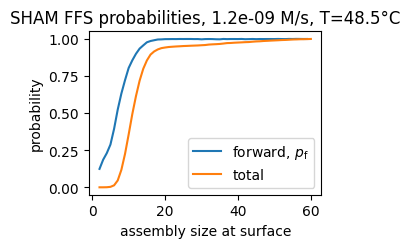

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2.12))
ax.plot(
    sd.get_column('target_size'),
    sd.get_column('p_r').shift(-1),
    label='forward, $p_\\text{f}$'
)
ax.plot(
    sd.get_column('target_size'),
    sd.get_column('p_r').to_numpy()[::-1].cumprod()[::-1],
    label='total'
)
ax.set_xlabel('assembly size at surface')
ax.set_ylabel('probability')
ax.set_title(f"SHAM FFS probabilities, {res.nucleation_rate:2.1e} M/s, T=48.5°C")
ax.legend()


Text(0.5, 1.0, 'Mean state times at FFS surfaces')

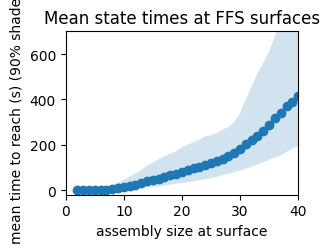

In [25]:
q = cd.group_by("size", maintain_order=True).agg(
    pl.col("time").quantile(0.5).alias("time_median"),
    pl.col("time").quantile(0.95).alias("time_95"),
    pl.col("time").quantile(0.05).alias("time_05"),
)
fig, ax = plt.subplots(figsize=(3, 2.12))#constrained_layout=True)
ax.plot(q["size"], q["time_median"], "o-")
ax.fill_between(q["size"], q["time_05"], q["time_95"], alpha=0.2)
ax.set_xlabel("assembly size at surface")
ax.set_ylabel("mean time to reach (s) (90% shaded)")
ax.set_xlim(0, 40)
ax.set_ylim(-20, 700)
ax.set_title("Mean state times at FFS surfaces")


Text(0.5, 0.98, 'Example size 20 FFS surface configurations')

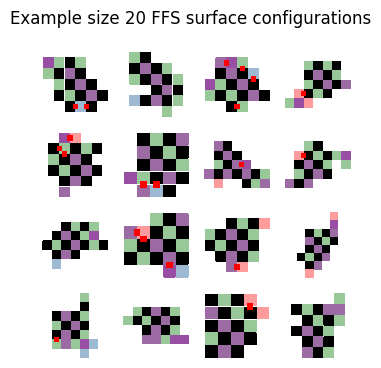

In [26]:
fig, axs = plt.subplots(4, 4, figsize=(4, 4))

cf = cd.filter(pl.col("size") == 20)

for i, ax in enumerate(axs.flat):
    canvas = cf[i, "canvas"].to_numpy().reshape(cf[i, "shape_i"], cf[i, "shape_j"])
    v = np.zeros((canvas.shape[0]+2, canvas.shape[1]+2), dtype=np.uint32)
    v[1:-1, 1:-1] = canvas
    state = rts._to_rg_tileset().create_state_from_canvas(v)
    ax = sys.plot_canvas(state, annotate_mismatches=True, ax=ax)
    xl = ax.get_xlim()
    ax.set_xlim(xl[0]+1, xl[1]-1)
    yl = ax.get_ylim()
    ax.set_ylim(yl[0]-1, yl[1]+1)
    ax.set_axis_off()
    #ax.set_title(f"size {cd[g+i, 'size']}; time {cd[g+i, 'time']} s")

fig.suptitle("Example size 20 FFS surface configurations")


Text(0.5, 0.98, 'Example size 60 FFS surface configurations')

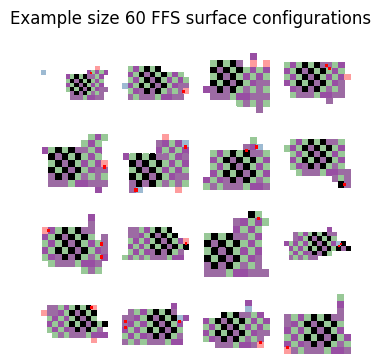

In [29]:
fig, axs = plt.subplots(4, 4, figsize=(4, 4))

cf = cd.filter(pl.col("size") == 60)

for i, ax in enumerate(axs.flat):
    canvas = cf[i, "canvas"].to_numpy().reshape(cf[i, "shape_i"], cf[i, "shape_j"])
    v = np.zeros((canvas.shape[0]+2, canvas.shape[1]+2), dtype=np.uint32)
    v[1:-1, 1:-1] = canvas
    state = rts._to_rg_tileset().create_state_from_canvas(v)
    ax = sys.plot_canvas(state, annotate_mismatches=True, ax=ax)
    xl = ax.get_xlim()
    ax.set_xlim(xl[0]+1, xl[1]-1)
    yl = ax.get_ylim()
    ax.set_ylim(yl[0]-1, yl[1]+1)
    ax.set_axis_off()
    #ax.set_title(f"size {cd[g+i, 'size']}; time {cd[g+i, 'time']} s")

fig.suptitle("Example size 60 FFS surface configurations")


In [30]:
recs = []
c = cd[-1]
while not c.is_empty():
    recs.append(c)
    c = cd.filter((pl.col("surface_index") == c['surface_index'][0]-1) & (pl.col("config_index") == c['previous_config'][0]))
traj = pl.concat(recs[::-1])

In [31]:
traj

surface_index,config_index,size,time,previous_config,canvas,min_i,min_j,shape_i,shape_j
u64,u64,u32,f64,u64,list[u32],u64,u64,u64,u64
0,20955,2,0.0,823,"[426, 823]",8,8,2,1
1,20955,3,0.938474,20955,"[654, 426, 823]",7,8,3,1
2,37408,4,1.1502,20955,"[212, 654, … 823]",6,8,4,1
3,50216,5,1.225129,37408,"[212, 0, … 0]",6,8,4,2
4,7147,6,1.509427,50216,"[0, 212, … 0]",6,7,4,3
…,…,…,…,…,…,…,…,…,…
54,795,56,882.337238,3295,"[0, 0, … 0]",3,4,7,10
55,1238,57,882.955863,795,"[0, 0, … 0]",2,4,8,10
56,3309,58,944.720203,1238,"[0, 0, … 0]",3,4,8,11


Text(0.5, 0.98, 'Example single-trajectory configurations')

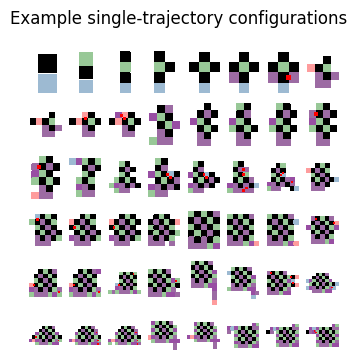

In [32]:
fig, axs = plt.subplots(6, 8, figsize=(4, 4))


for z, ax in zip(traj.iter_rows(named=True), axs.flat):
    canvas = np.array(z["canvas"], dtype=np.uint32).reshape(z["shape_i"], z["shape_j"])
    v = np.zeros((canvas.shape[0]+2, canvas.shape[1]+2), dtype=np.uint32)
    v[1:-1, 1:-1] = canvas
    state = rts._to_rg_tileset().create_state_from_canvas(v)
    ax = sys.plot_canvas(state, annotate_mismatches=True, ax=ax)
    xl = ax.get_xlim()
    ax.set_xlim(xl[0]+1, xl[1]-1)
    yl = ax.get_ylim()
    ax.set_ylim(yl[0]-1, yl[1]+1)
    ax.set_axis_off()
    #ax.set_title(f"size {cd[g+i, 'size']}; time {cd[g+i, 'time']} s")

fig.suptitle("Example single-trajectory configurations")
# fig.savefig(f'{PREFIX}-sham-example-trajectory.pdf')

# canvas = cd[g, "canvas"].to_numpy().reshape(cd[g, "shape_i"], cd[g, "shape_j"])
# v = np.zeros((canvas.shape[0]+2, canvas.shape[1]+2), dtype=np.uint32)
# v[1:-1, 1:-1] = canvas
# state = rts._to_rg_tileset().create_state_from_canvas(v)
# ax = sys.plot_canvas(state, annotate_tiles=True, annotate_mismatches=True, ax=ax)
# ax.set_axis_off()
# # ax.set_ylim( 5.5, 0.5)
# # ax.set_xlim(0.5, 7.5)
# ax.set_title("SHAM example state: size 19; time 207 s")
# # ax.get_figure().savefig('sham-example-state.pdf')

In [33]:
uh = np.array([re.match('[H]', x) is not None for x in sys.tile_names])
ua = np.array([re.match('[A]', x) is not None for x in sys.tile_names])
um = np.array([re.match('[M]', x) is not None for x in sys.tile_names])

In [37]:
cd = cd.with_columns(
    n_h=pl.col("canvas").map_elements(lambda x: uh[x].sum(), return_dtype=pl.Float64),
    n_a=pl.col("canvas").map_elements(lambda x: ua[x].sum(), return_dtype=pl.Float64),
    n_m=pl.col("canvas").map_elements(lambda x: um[x].sum(), return_dtype=pl.Float64),
).with_columns(
    p_h=pl.col("n_h") / pl.col("size"),
    p_a=pl.col("n_a") / pl.col("size"),
    p_m=pl.col("n_m") / pl.col("size"),
)
mm = cd.group_by("size", maintain_order=True).agg(
    h = (pl.col("p_h") > 0.2).mean(),
    a = (pl.col("p_a") > 0.2).mean(),
    m = (pl.col("p_m") > 0.2).mean()
)

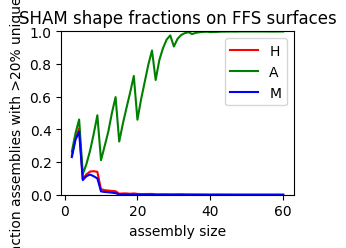

In [39]:
fig, ax = plt.subplots(figsize=(3, 2.12))
ax.plot(mm['size'], mm['h'], color='red', label='H')
ax.plot(mm['size'], mm['a'], color='green', label='A')
ax.plot(mm['size'], mm['m'], color='blue', label='M')
ax.set_ylim(0, 1)
ax.set_ylabel("fraction assemblies with >20% unique tiles")
ax.set_xlabel("assembly size")
ax.set_title("SHAM shape fractions on FFS surfaces")
ax.legend()

Text(0.5, 0.98, 'SHAM unique tile count histograms for FFS surfaces')

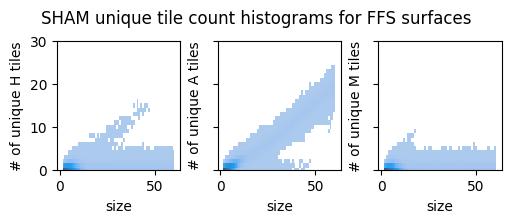

In [41]:
s = "a"
fig, axs = plt.subplots(1, 3, figsize=(5, 2.12), constrained_layout=True)

for s, ax in zip(['h', 'a', 'm'], axs):
    sns.histplot(x=cd['size'], y=cd[f'n_{s}'], discrete=True, ax=ax)# , bins=50) # , height=2)
    ax.set_ylabel(f"# of unique {s.upper()} tiles")
    if s != 'h':
        ax.set_yticklabels([])
    ax.set_ylim(0, 30)

fig.suptitle("SHAM unique tile count histograms for FFS surfaces")
# fig.savefig(f'{PREFIX}-sham-unique-tile-histograms.pdf')
#sns.histplot(x=cd['size'], y=cd['n_h'], discrete=True)# , bins=50) # , height=2)
#sns.histplot(x=cd['size'], y=cd['n_m'], discrete=True)# , bins=50) # , height=2)